In [ ]:
# Inference Export Test

In [1]:
import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from utils.google_utils import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer)
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

from models.models import *
from utils.datasets import *
from utils.general import *

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:

names = ['vehicle', 'person']


In [13]:
names

['vehicle', 'person']

In [14]:
# Load model
imgsz=640
device='cuda'
half=True 
weights= ['/nvmefs1/andrew.mendez/yolov4_train_runs/fmv_train_exp/weights/best_overall.pt']
model = Darknet('/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/2024/PyTorch_YOLOv4/cfg/yolov4-pacsp-fmv.cfg',img_size=imgsz).cuda()
try:
    model.load_state_dict(torch.load(weights[0], map_location=device)['model'])
    #model = attempt_load(weights, map_location=device)  # load FP32 model
    #imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
except:
    print("Failed")
    load_darknet_weights(model, weights[0])
model.to(device).eval()
if half:
    model.half()  # to FP16

/opt/conda/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
from PIL import Image
import numpy as np
IMG_PATH='/nvmefs1/andrew.mendez/virat-aerial-156-frames-v2-coco-yolov5/train/000022.png'
image = Image.open(IMG_PATH)

In [26]:
dataset = LoadImages(IMG_PATH, img_size=imgsz, auto_size=64)

In [27]:
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    print(img.shape,im0s.shape)
    pred = model(img, augment=False)[0]
    conf_thres=0.4
    iou_thres=0.3
    is_coco=False
    coco91class = coco80_to_coco91_class()
    pred = non_max_suppression(pred, 
                               conf_thres, 
                               iou_thres, 
                               classes=None, 
                               agnostic=False)[0]
    path=Path('/nvmefs1/andrew.mendez/virat-aerial-156-frames-v2-coco-yolov5/train/000022.png')
    image_id = int(path.stem) if path.stem.isnumeric() else path.stem
    # for si,p in enumerate(pred):
    # print(pred[0][:, :4])
    box = pred[:, :4].clone()  # xyxy
    # print(im0s[si][0], im0s[si][1])
    scale_coords(img.shape[2:], box, im0s.shape)  # to original shape
    box = xyxy2xywh(box).detach().cpu().numpy()  # xywh
    jdict = []
    box[:, :2] = np.maximum(box[:, :2] - box[:, 2:] / 2, 0) # xy center to top-left corner
    for p, b in zip(pred.tolist(), box.tolist()):
        jdict.append({'image_id': image_id,
                      'category_id': names[int(p[5])],
                      'bbox': [round(x, 3) for x in b],
                      'score': round(p[4], 5)})
# img

image 1/1 /nvmefs1/andrew.mendez/virat-aerial-156-frames-v2-coco-yolov5/train/000022.png: torch.Size([1, 3, 448, 640]) (480, 720, 3)


In [28]:
# jdict

In [29]:
from PIL import Image,ImageDraw

draw = ImageDraw.Draw(image)
# Optional: Load a font, if you want a specific font or size
# font = ImageFont.truetype("arial.ttf", 15)  # Example: Arial, size 15
for box in jdict:
    x, y, w, h = box['bbox']
    draw.rectangle([x, y, x + w, y + h], outline="red")

    # Prepare the text to display
    text = f"ID: {box['category_id']}, Score: {box['score']:.2f}"
    
    # Draw text. If you loaded a font, add `, font=font` in the text() function
    draw.text((x, y), text, fill="yellow")

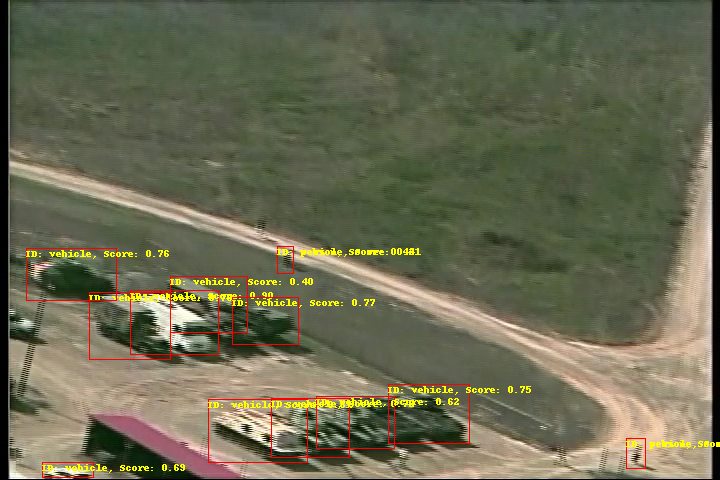

In [30]:
image